# Load Spark

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/31 15:35:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
combined_df = spark.table("dn_labels_combined")

# Create dedup data

In [11]:
combined_distinct_df = combined_df.distinct().orderBy("id", "label", "type")

dedup_data = combined_distinct_df.toPandas()

null_count = dedup_data[dedup_data["id"].isnull()].shape[0]
# format null_nums 5 digit number starting from 00000
null_nums = [f"null{num:05d}" for num in range(0, null_count)]
dedup_data.loc[dedup_data["id"].isnull(), "id"] = null_nums
dedup_data.loc[dedup_data["type"].isnull(), "type"] = "missing"
# Name index idx
dedup_data.index.name = "idx"

dedup_data

,label,id,type,source
idx,,,,
0,Children,null00000,missing,subject
1,Criminal law,null00001,missing,subject
2,Gender roles,null00002,missing,subject
3,Law,null00003,missing,subject
4,Police,null00004,missing,subject
...,...,...,...,...
646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor


### Find rows that label contains "Florence"

In [24]:
florence_rows = dedup_data[dedup_data['label'].str.contains(
    "Florence", case=False, na=False) & dedup_data['label'].str.contains(
    "N.", case=False, na=False)].sort_values(by='id', ascending=True)
florence_rows

,label,id,type,source
idx,,,,
369,"Seibert, Florence B., 1897-1991.",a2eja6h3,Person,subject
1794,"Starling, Florence A.",a3y59bbc,Person,contributor
7078,"Lees, Florence Sarah, 1840-1922.",a9qbyauq,Person,subject
8840,"Fitzgerald, Alice Louise Florence, 1874-1962.",abjapcbz,Person,contributor
10489,"Brown, Florence Haig (Florence Amelia Haig)",adddjcfv,Person,contributor
...,...,...,...,...
638080,"La Live, Louise Florence Pétronille, marquise ...",zqmczs9w,Person,subject
638861,"Gardiner, Florence Mary.",zrf8dcpg,Person,contributor
640338,"Ball, Florence V.",zsyewr24,Person,contributor


In [ ]:
from wc_simd.dedupe_service import dedup_data_file

# Convert all columns to string type
dedup_data = dedup_data.astype(str)
dedup_data.reset_index(inplace=True)
dedup_data.rename(columns={"index": "idx"}, inplace=True)

dedup_data.to_csv("../" + dedup_data_file, index=True)

## Load dedup data

In [6]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file
dedup_data = pd.read_csv("../" + dedup_data_file, index_col=0)

# force all columns to string type
dedup_data = dedup_data.astype(str)

dedup_data

,label,id,type,source
idx,,,,
0,Children,null00000,missing,subject
1,Criminal law,null00001,missing,subject
2,Gender roles,null00002,missing,subject
3,Law,null00003,missing,subject
4,Police,null00004,missing,subject
...,...,...,...,...
646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor


# Create blocking map

### Spark Blocking

In [ ]:
dedup_data_df = spark.createDataFrame(dedup_data)

In [ ]:
dedup_data_df.rdd.getNumPartitions()

64

In [ ]:
dedup_data_df.show()

+---+--------------------+---------+-------+-----------+
|idx|               label|       id|   type|     source|
+---+--------------------+---------+-------+-----------+
|  0|            Children|null00000|missing|    subject|
|  1|        Criminal law|null00001|missing|    subject|
|  2|        Gender roles|null00002|missing|    subject|
|  3|                 Law|null00003|missing|    subject|
|  4|              Police|null00004|missing|    subject|
|  5|               Women|null00005|missing|    subject|
|  6|               Womyn|null00006|missing|    subject|
|  7|               Youth|null00007|missing|    subject|
|  8|Circle of State L...| a2233f9d|Meeting|contributor|
|  9|Nelson, Geoffrey ...| a223f5a6| Person|contributor|
| 10|           Wolff, G.| a2249bxm| Person|contributor|
| 11|       Jones, John E| a224b9mp| Person|contributor|
| 12|      Jones, John E.| a224b9mp| Person|contributor|
| 13|Hulverscheidt, Ma...| a224rx5x| Person|contributor|
| 14|Zimmermann, Wilhelm.| a224

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
from wc_simd.dedupe_service import settings_file
from dedupe import StaticDedupe
from typing import Iterator


def block_pandas(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:

    for pdf in iterator:
        with open("../" + settings_file, 'rb') as f:
            dedupe = StaticDedupe(f, num_cores=1)

        for field in dedupe.fingerprinter.index_fields:
            field_data = pdf[field].dropna().unique()
            dedupe.fingerprinter.index(field_data, field)

        fingerprint_data = ((row.idx, dict(label=row.label, type=row.type))
                            for idx, row in pdf.iterrows())
        blocked_data = dedupe.fingerprinter(fingerprint_data)

        yield pd.DataFrame(blocked_data, columns=["block_key", "idx"])


blocked_schema = StructType([
    StructField("block_key", StringType(), True),
    StructField("idx", IntegerType(), True),
])

blocked_df = dedup_data_df.mapInPandas(
    block_pandas, schema=blocked_schema)
blocked_df.show()

+---------+---+
|block_key|idx|
+---------+---+
|      1:0|  0|
|      1:1|  0|
|      2:0|  1|
|      3:0|  2|
|      4:0|  3|
|      4:1|  3|
|      5:0|  4|
|      6:0|  5|
|      6:1|  5|
|      6:0|  6|
|      7:1|  6|
|      8:0|  7|
|      8:1|  7|
|      9:0|  8|
|     10:0|  9|
|     10:1|  9|
|     11:0| 10|
|     11:1| 10|
|     12:0| 11|
|     12:1| 11|
+---------+---+
only showing top 20 rows



In [ ]:
blocked_df.write.mode("overwrite").saveAsTable("dn_label_blocks")

In [ ]:
blocked_df = spark.table("dn_label_blocks")

In [ ]:
blocking_map_df = blocked_df.toPandas()
# blocking_map_df.set_index("idx", inplace=True, drop=False)
blocking_map_df

,block_key,idx
0,1:0,141312
1,2:0,141313
2,2:1,141313
3,3:0,141314
4,4:0,141315
...,...,...
938455,8587:1,9212
938456,8587:0,9213
938457,8587:1,9213
938458,8588:0,9214


### Non-Spark blocking

In [ ]:
from wc_simd.dedupe_service import settings_file
from dedupe import StaticDedupe


with open("../" + settings_file, 'rb') as f:
    dedupe = StaticDedupe(f, num_cores=8)

for field in dedupe.fingerprinter.index_fields:
    print(f"Indexing field: {field}")
    field_data = dedup_data[field].dropna().unique()
    dedupe.fingerprinter.index(field_data, field)

fingerprint_data = ((idx, dict(label=row.label, type=row.type)) for idx, row in dedup_data.iterrows())
blocked_data = dedupe.fingerprinter(fingerprint_data)

INFO:dedupe.api:Predicate set:
INFO:dedupe.api:SimplePredicate: (firstTwoTokensPredicate, label)
INFO:dedupe.api:SimplePredicate: (oneGramFingerprint, label)


In [ ]:
blocking_map_df = pd.DataFrame(blocked_data, columns=["block_key", "idx"])
blocking_map_df.set_index("block_key", inplace=True)
blocking_map_df.to_csv("../data/dn_blocking_map.csv", index=True)
blocking_map_df

INFO:dedupe.blocking:10000, 0.6576412 seconds
INFO:dedupe.blocking:20000, 1.2528772 seconds
INFO:dedupe.blocking:30000, 1.8461682 seconds
INFO:dedupe.blocking:40000, 2.4414742 seconds
INFO:dedupe.blocking:50000, 3.0324152 seconds
INFO:dedupe.blocking:60000, 3.6229272 seconds
INFO:dedupe.blocking:70000, 4.2134852 seconds
INFO:dedupe.blocking:80000, 4.8062192 seconds
INFO:dedupe.blocking:90000, 5.3969642 seconds
INFO:dedupe.blocking:100000, 5.9892732 seconds
INFO:dedupe.blocking:110000, 6.5806282 seconds
INFO:dedupe.blocking:120000, 7.1722862 seconds
INFO:dedupe.blocking:130000, 7.7620202 seconds
INFO:dedupe.blocking:140000, 8.3527662 seconds
INFO:dedupe.blocking:150000, 8.9478982 seconds
INFO:dedupe.blocking:160000, 9.5412722 seconds
INFO:dedupe.blocking:170000, 10.1313692 seconds
INFO:dedupe.blocking:180000, 10.7233462 seconds
INFO:dedupe.blocking:190000, 11.3171742 seconds
INFO:dedupe.blocking:200000, 11.9110692 seconds
INFO:dedupe.blocking:210000, 12.5069032 seconds
INFO:dedupe.block

,idx
block_key,
Cdehilnr:1,0
Criminal law:0,1
Cailmnrw:1,1
Gender roles:0,2
Gdelnors:1,2
...,...
RWacdefhiklmor:1,646783
Aneurysm drug:0,646784
Aadeghmnprstuy:1,646784


In [ ]:
# Check idx column type
blocking_map_df["idx"] = blocking_map_df["idx"].astype(int)

In [ ]:
blocking_map_df

,idx
block_key,
Cdehilnr:1,0
Criminal law:0,1
Cailmnrw:1,1
Gender roles:0,2
Gdelnors:1,2
...,...
RWacdefhiklmor:1,646783
Aneurysm drug:0,646784
Aadeghmnprstuy:1,646784


In [ ]:
blocking_map_df.groupby("block_key").size().sort_values(ascending=False)

block_key
Great Britain:0             2328
University of:0             1608
United States:0             1094
Symposium on:0               756
International Congress:0     588
                            ... 
CEHUadeghilnoprstvy:1          1
CEHWabdfgilnoprstuy:1          1
CEHWacdefghilnorstuy:1         1
CEHWacdefilmnorstuvz:1         1
賀川 子玄:0                        1
Length: 920565, dtype: int64

# Prep dictionary pairs

In [ ]:
full_data_df = pd.DataFrame(((idx, dict(label=row["label"], type=row["type"]))
                            for idx, row in dedup_data.iterrows()), columns=["idx", "dict"])
full_data_df.set_index("idx", inplace=True)
full_data_df

,dict
idx,
0,"{'label': 'Children', 'type': 'missing'}"
1,"{'label': 'Criminal law', 'type': 'missing'}"
2,"{'label': 'Gender roles', 'type': 'missing'}"
3,"{'label': 'Law', 'type': 'missing'}"
4,"{'label': 'Police', 'type': 'missing'}"
...,...
646781,{'label': 'Pregnant teenagers - Great Britain ...
646782,"{'label': 'Maddox, Lucy', 'type': 'Person'}"
646783,"{'label': 'Rockliffe, Richard William.', 'type..."


## Join dictionary pairs with blocking map

In [ ]:
blocking_result_df = (blocking_map_df
                      .join(blocking_map_df, rsuffix="_r", on="block_key")
             .query('idx < idx_r')
             .join(full_data_df, on="idx")
             .join(full_data_df, on="idx_r", rsuffix="_r")
             )
blocking_result_df

,idx,idx_r,dict,dict_r
block_key,,,,
Cdehilnr:1,0,228859,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Cdehilnr:1,0,264402,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Criminal law:0,1,102628,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law (Roman law) - Early wo...
Criminal law:0,1,180893,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law - United States - Hist...
Criminal law:0,1,306835,"{'label': 'Criminal law', 'type': 'missing'}","{'label': 'Criminal law', 'type': 'Concept'}"
...,...,...,...,...
123678CMWabdefhilnorstvw:1,646760,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
Mather Cotton:0,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
123678CMWabdefhilnorstvw:1,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."


In [ ]:
blocking_result_df.to_parquet("../data/dn_labels_blocking_map.parquet", index=True)

In [1]:
import pandas as pd
blocking_result_df = pd.read_parquet("../data/dn_labels_blocking_map.parquet")

In [2]:
blocking_result_df

,idx,idx_r,dict,dict_r
block_key,,,,
Cdehilnr:1,0,228859,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Cdehilnr:1,0,264402,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Criminal law:0,1,102628,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law (Roman law) - Early wo...
Criminal law:0,1,180893,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law - United States - Hist...
Criminal law:0,1,306835,"{'label': 'Criminal law', 'type': 'missing'}","{'label': 'Criminal law', 'type': 'Concept'}"
...,...,...,...,...
123678CMWabdefhilnorstvw:1,646760,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
Mather Cotton:0,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
123678CMWabdefhilnorstvw:1,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."


# Train Model

In [ ]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file

dedup_data = pd.read_csv("../" + dedup_data_file)

In [ ]:
train_data = {idx: {"label": row.label, "type": row.type}
              for idx, row in dedup_data.iterrows()}

In [ ]:
import dedupe
from wc_simd.dedupe_service import training_file, settings_file, fields

dedupe = dedupe.Dedupe(fields, num_cores=8)
with open("../" + training_file) as tf:
    dedupe.prepare_training(train_data, training_file=tf)
    dedupe.train(recall=0.90)
    with open("../" + settings_file, "wb") as sf:
        dedupe.write_settings(sf)
    dedupe.cleanup_training()

INFO:dedupe.api:reading training from file
INFO:dedupe.canopy_index:Removing stop word  A
INFO:dedupe.canopy_index:Removing stop word  E
INFO:dedupe.canopy_index:Removing stop word  M
INFO:dedupe.canopy_index:Removing stop word  R
INFO:dedupe.canopy_index:Removing stop word ac
INFO:dedupe.canopy_index:Removing stop word al
INFO:dedupe.canopy_index:Removing stop word ca
INFO:dedupe.canopy_index:Removing stop word ce
INFO:dedupe.canopy_index:Removing stop word d 
INFO:dedupe.canopy_index:Removing stop word di
INFO:dedupe.canopy_index:Removing stop word e 
INFO:dedupe.canopy_index:Removing stop word ed
INFO:dedupe.canopy_index:Removing stop word en
INFO:dedupe.canopy_index:Removing stop word er
INFO:dedupe.canopy_index:Removing stop word he
INFO:dedupe.canopy_index:Removing stop word ic
INFO:dedupe.canopy_index:Removing stop word in
INFO:dedupe.canopy_index:Removing stop word l 
INFO:dedupe.canopy_index:Removing stop word la
INFO:dedupe.canopy_index:Removing stop word ma
INFO:dedupe.canop

# Load Model

In [5]:
from dedupe import StaticDedupe
from wc_simd.dedupe_service import settings_file

with open("../" + settings_file, 'rb') as f:
    dedupe = StaticDedupe(f, num_cores=8)

INFO:dedupe.api:Predicate set:
INFO:dedupe.api:SimplePredicate: (firstTwoTokensPredicate, label)
INFO:dedupe.api:SimplePredicate: (oneGramFingerprint, label)
INFO:dedupe.api:SimplePredicate: (firstTwoTokensPredicate, label)
INFO:dedupe.api:SimplePredicate: (oneGramFingerprint, label)


# Score Clusters

In [ ]:
blocking_result_df.reset_index()["block_key"].unique().shape

(166716,)

In [ ]:
blocking_result_df.groupby("block_key").size().sort_values(ascending=False)

block_key
Great Britain:0             2708628
University of:0             1292028
United States:0              597871
Symposium on:0               285390
International Congress:0     172578
                             ...   
Commedia dellarte:0               1
Commandments Six:0                1
Commandments Judaism:0            1
Command of:0                      1
宇川玄田真:1                           1
Length: 166716, dtype: int64

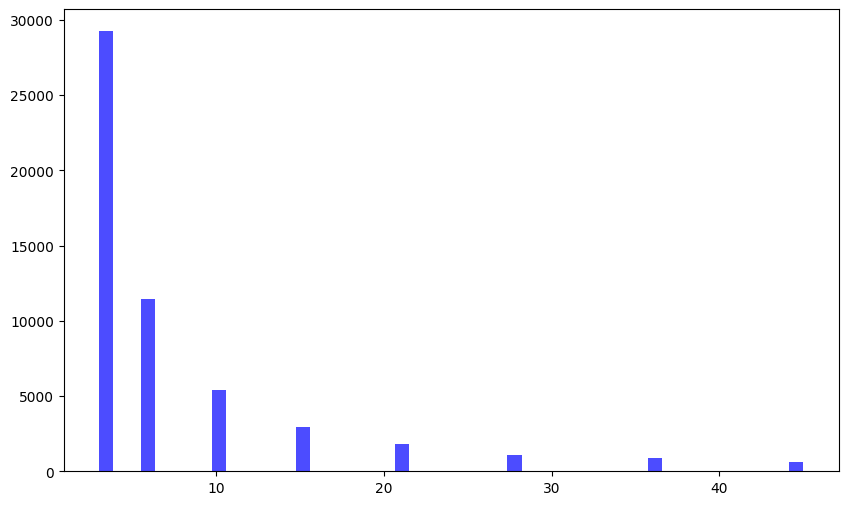

Block sizes statistics:
count    53363.000000
mean         7.129640
std          7.670314
min          3.000000
25%          3.000000
50%          3.000000
75%          6.000000
max         45.000000
dtype: float64


In [ ]:
# Histogram of block sizes
import matplotlib.pyplot as plt
%matplotlib inline

block_sizes = blocking_result_df.groupby("block_key").size()
#filter block sizes greater less than 50
block_sizes = block_sizes[(block_sizes < 50) & (block_sizes > 1)]
plt.figure(figsize=(10, 6))
plt.hist(block_sizes, bins=50, color='blue', alpha=0.7)
# plt.title('Distribution of Block Sizes')
# plt.xlabel('Block Size')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.grid(axis='y', alpha=0.75)
plt.show()

print("Block sizes statistics:")
print(block_sizes.describe())

In [15]:
blocking_result_df.shape

(7797058, 4)

In [19]:
# sample_to_cluster_df = blocking_result_df.head(1000000)
sample_to_cluster_df = blocking_result_df
sample_to_cluster_df.shape

(7797058, 4)

In [20]:
cluster_data = (((row["idx"], row["dict"]), (row["idx_r"], row["dict_r"]))
                for idx, row in sample_to_cluster_df.iterrows())

clustered_dupes = dedupe.cluster(
    dedupe.score(cluster_data),
    threshold=0.5)

In [21]:

def cluster_ids(clustered_dupes):
    for cluster, scores in clustered_dupes:
        cluster_id = cluster[0]
        for entry_id, score in zip(cluster, scores):
            if entry_id == cluster_id:
                continue
            yield entry_id, cluster_id, score

clustered_dupes_df = pd.DataFrame(cluster_ids(clustered_dupes), columns=["id", "canon_id", "prob"]).set_index("id")
clustered_dupes_df

,canon_id,prob
id,,
228859,0,0.554309
264402,0,0.554309
306835,1,0.543765
306836,1,0.469971
323958,1,0.543765
...,...,...
646577,646576,0.633294
646681,646680,0.620203
646696,646695,0.602892


In [22]:
clustered_dupes_df.to_csv("../data/dn_labels_clustered_dupes.csv", index=True)

In [16]:
import pandas as pd

clustered_dupes_df = pd.read_csv("../data/dn_labels_clustered_dupes.csv", index_col="id")
clustered_dupes_df.sort_values(by="canon_id", ascending=False)

,canon_id,prob
id,,
646766,646765,0.633294
646761,646760,0.490453
646762,646760,0.554825
646700,646698,0.557174
646699,646698,0.588207
...,...,...
323958,1,0.543765
306836,1,0.469971
306835,1,0.543765


In [14]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file

dedup_data = pd.read_csv("../" + dedup_data_file, index_col=0)
dedup_data_indexed = dedup_data[["label", "type"]]

In [20]:
dedup_df = (
    clustered_dupes_df
    .join(dedup_data_indexed)
    .reset_index()
    .set_index("canon_id")
    .join(dedup_data_indexed, rsuffix="_canon")
    .query("prob > 0.52")
    # .sort_values(by=["canon_id"], ascending=True)
    
)
dedup_df

,id,prob,label,type,label_canon,type_canon
canon_id,,,,,,
0,228859,0.554309,Children,Concept,Children,missing
0,264402,0.554309,Children,Concept,Children,missing
1,306835,0.543765,Criminal law,Concept,Criminal law,missing
1,323958,0.543765,Criminal law,Concept,Criminal law,missing
180893,578269,0.571528,Criminal law - United States,Concept,Criminal law - United States - History,Concept
...,...,...,...,...,...,...
646576,646577,0.633294,"Nossal, G. J. V. (Gustav Joseph Victor), 1931-",Person,"Nossal, G. J. V. (Gustav Joseph Victor), 1931-",Person
646680,646681,0.620203,"Pickering, Percival Spencer Umfreville, 1858-1...",Agent,"Pickering, Percival Spencer Umfreville, 1858-1920",Agent
646695,646696,0.602892,Holt Radium Institute.,Organisation,Holt Radium Institute,Organisation


In [21]:
dedup_df[~(dedup_df["label"] == dedup_df["label_canon"])]

,id,prob,label,type,label_canon,type_canon
canon_id,,,,,,
180893,578269,0.571528,Criminal law - United States,Concept,Criminal law - United States - History,Concept
11,227945,0.581322,"Jones, John",Person,"Jones, John E",Person
11,466558,0.581322,"Jones, John",Person,"Jones, John E",Person
178143,374674,0.530015,"Jones, John Gale, 1769-1838",Person,"Jones, John Gale",Person
195492,488607,0.525187,"Jones, John Paul",Person,"Jones, John Paul, 1747-1792.",Person
...,...,...,...,...,...,...
646563,646564,0.538905,County Councils Association.,Organisation,County Councils Association,Agent
646680,646681,0.620203,"Pickering, Percival Spencer Umfreville, 1858-1...",Agent,"Pickering, Percival Spencer Umfreville, 1858-1920",Agent
646695,646696,0.602892,Holt Radium Institute.,Organisation,Holt Radium Institute,Organisation


## Check Florence Nightingale

In [22]:
# select rows where label contains "Florence" and "Night

dedup_df[dedup_df['label'].str.contains(
    "Florence", case=False, na=False) & dedup_df['label'].str.contains(
    "Night", case=False, na=False)].sort_values(by='canon_id', ascending=True)

,id,prob,label,type,label_canon,type_canon
canon_id,,,,,,
87516,184753,0.537656,"Nightingale, Florence, 1820-1910",Person,"Nightingale, Florence, 1820-1910.",Person
87516,184754,0.537656,"Nightingale, Florence, 1820-1910",Person,"Nightingale, Florence, 1820-1910.",Person
87516,184756,0.545801,"Nightingale, Florence, 1820-1910.",Person,"Nightingale, Florence, 1820-1910.",Person
87516,184757,0.545801,"Nightingale, Florence, 1820-1910.",Person,"Nightingale, Florence, 1820-1910.",Person
87516,272387,0.545801,"Nightingale, Florence, 1820-1910.",Person,"Nightingale, Florence, 1820-1910.",Person
87900,267509,0.602724,Florence Nightingale Museum,Organisation,"Florence Nightingale Museum (London, England)",Organisation
87900,418369,0.602724,Florence Nightingale Museum,Organisation,"Florence Nightingale Museum (London, England)",Organisation
87900,418370,0.602724,Florence Nightingale Museum,Organisation,"Florence Nightingale Museum (London, England)",Organisation
87900,418371,0.558210,Florence Nightingale Museum.,Organisation,"Florence Nightingale Museum (London, England)",Organisation


## Select Dis-similar rows based on FuzzyWuzzy

In [ ]:
# Install fuzzywuzzy if not available
from fuzzywuzzy import fuzz

# Add similarity score column
dedup_df['similarity_score'] = dedup_df.apply(
    lambda row: fuzz.ratio(str(row['label']), str(row['label_canon'])), axis=1
)

# Filter out rows where labels are very similar (e.g., similarity > 90)
similarity_threshold = 90
filtered_dedup_df = dedup_df[dedup_df['similarity_score'] < similarity_threshold]

print(f"Original rows: {len(dedup_df)}")
print(f"Filtered rows (similarity < {similarity_threshold}): {len(filtered_dedup_df)}")
print(f"Removed {len(dedup_df) - len(filtered_dedup_df)} rows with high similarity")

# Show some examples of what was filtered out
high_similarity_df = dedup_df[dedup_df['similarity_score'] >= similarity_threshold]
print(f"\nExample of filtered out rows (high similarity):")
if len(high_similarity_df) > 0:
    print(high_similarity_df[['label', 'label_canon', 'similarity_score']].head())
else:
    print("No rows with high similarity found")

filtered_dedup_df

Original rows: 3132
Filtered rows (similarity < 90): 1095
Removed 2037 rows with high similarity

Example of filtered out rows (high similarity):
                                                      label  \
canon_id                                                      
218898                                     Ashworth, Bryan.   
338357                 Pettigrew, Thomas Joseph, 1791-1865.   
639846                                      Rivers, Isabel.   
518760                          Scriven, Edward, 1775-1841.   
104248    Lichfield, Sutton Coldfield and Tamworth Hospi...   

                                                label_canon  similarity_score  
canon_id                                                                       
218898                                     Ashworth, Bryan.               100  
338357                 Pettigrew, Thomas Joseph, 1791-1865.               100  
639846                                       Rivers, Isabel                97  
518760      

,id,canon_id,prob,label,type,label_canon,type_canon,similarity_score
canon_id,,,,,,,,
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept,78
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept,80
527276,624262,527276,0.531998,"Newman, John",Person,"Newman, John B.",Person,89
79172,443059,79172,0.539905,"Adaptation, Physiological",Concept,"Adaptation, Physiological - physiology",Concept,79
625121,625123,625121,0.520070,Pathogenic fungi - Nomenclature,Concept,Pathogenic fungi,Concept,68
...,...,...,...,...,...,...,...,...
22578,624994,22578,0.524425,"Barr, James Smith",Person,"Barr, James",Person,79
506121,506123,506121,0.533860,"Najīb al-Dīn al-Samarqandī, Muḥammad ibn ʻAlī,...",Person,"Najīb al-Dīn al-Samarqandī, Muḥammad ibn ʻAlī,...",Person,82
88869,239257,88869,0.530660,Cape of Good Hope (S.A.),Place,Cape of Good Hope,Place,83


In [ ]:
filtered_dedup_df.to_csv("../data/dn_labels_filtered_dedup_result.csv", index=True)

In [ ]:
filtered_dedup_df.columns

Index(['id', 'canon_id', 'prob', 'label', 'type', 'label_canon', 'type_canon',
       'similarity_score'],
      dtype='object')

In [ ]:
# Analyze similarity score distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Histogram of similarity scores
plt.subplot(1, 2, 1)
plt.hist(dedup_df['similarity_score'], bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.axvline(x=similarity_threshold, color='red', linestyle='--', label=f'Threshold: {similarity_threshold}')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(dedup_df['similarity_score'])
plt.title('Similarity Score Box Plot')
plt.ylabel('Similarity Score')

plt.tight_layout()
plt.show()

print("Similarity score statistics:")
print(dedup_df['similarity_score'].describe())

# Show examples at different similarity ranges
print("\n--- Examples by similarity range ---")

# Very different labels (low similarity)
low_sim = dedup_df[dedup_df['similarity_score'] < 30]
if len(low_sim) > 0:
    print(f"\nVery different labels (similarity < 30): {len(low_sim)} rows")
    print(low_sim[['label', 'label_canon', 'similarity_score']].head(3))

# Moderately similar labels
med_sim = dedup_df[(dedup_df['similarity_score'] >= 30) & (dedup_df['similarity_score'] < 70)]
if len(med_sim) > 0:
    print(f"\nModerately similar labels (30-70): {len(med_sim)} rows")
    print(med_sim[['label', 'label_canon', 'similarity_score']].head(3))

# Very similar labels (high similarity)
high_sim = dedup_df[dedup_df['similarity_score'] >= 70]
if len(high_sim) > 0:
    print(f"\nVery similar labels (similarity >= 70): {len(high_sim)} rows")
    print(high_sim[['label', 'label_canon', 'similarity_score']].head(3))

Similarity score statistics:
count    3132.000000
mean       90.931992
std        11.392710
min        33.000000
25%        80.000000
50%        98.000000
75%       100.000000
max       100.000000
Name: similarity_score, dtype: float64

--- Examples by similarity range ---

Moderately similar labels (30-70): 92 rows
                                                   label  \
canon_id                                                   
625121                   Pathogenic fungi - Nomenclature   
139552    Hay, William, 1695-1755. Deformity : an essay.   
75900                    Poultry Diseases - drug therapy   

                       label_canon  similarity_score  
canon_id                                              
625121            Pathogenic fungi                68  
139552    Hay, William, 1695-1755.                69  
75900             Poultry Diseases                68  

Very similar labels (similarity >= 70): 3040 rows
                                                  label

In [ ]:
# Function to filter by different similarity thresholds
def filter_by_similarity(df, threshold=90, show_examples=True):
    filtered_df = df[df['similarity_score'] < threshold]
    removed_count = len(df) - len(filtered_df)
    
    print(f"Threshold: {threshold}")
    print(f"Original rows: {len(df)}")
    print(f"Filtered rows: {len(filtered_df)}")
    print(f"Removed rows: {removed_count} ({removed_count/len(df)*100:.1f}%)")
    
    if show_examples and removed_count > 0:
        removed_df = df[df['similarity_score'] >= threshold]
        print(f"\nExamples of removed rows (similarity >= {threshold}):")
        print(removed_df[['label', 'label_canon', 'similarity_score', 'prob']].head())
    
    return filtered_df

# Try different thresholds
print("=== Experimenting with different similarity thresholds ===\n")

for threshold in [95, 90, 85, 80, 75]:
    print("-" * 50)
    filtered_result = filter_by_similarity(dedup_df, threshold, show_examples=(threshold == 90))
    print()

# You can adjust this threshold based on your needs
final_threshold = 85  # Adjust this value
final_filtered_df = filter_by_similarity(dedup_df, final_threshold, show_examples=True)

print(f"\n=== Final filtered dataframe with threshold {final_threshold} ===")
final_filtered_df.head(10)

=== Experimenting with different similarity thresholds ===

--------------------------------------------------
Threshold: 95
Original rows: 3132
Filtered rows: 1165
Removed rows: 1967 (62.8%)

--------------------------------------------------
Threshold: 90
Original rows: 3132
Filtered rows: 1095
Removed rows: 2037 (65.0%)

Examples of removed rows (similarity >= 90):
                                                      label  \
canon_id                                                      
218898                                     Ashworth, Bryan.   
338357                 Pettigrew, Thomas Joseph, 1791-1865.   
639846                                      Rivers, Isabel.   
518760                          Scriven, Edward, 1775-1841.   
104248    Lichfield, Sutton Coldfield and Tamworth Hospi...   

                                                label_canon  similarity_score  \
canon_id                                                                        
218898                   

,id,canon_id,prob,label,type,label_canon,type_canon,similarity_score
canon_id,,,,,,,,
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept,78
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept,80
79172,443059,79172,0.539905,"Adaptation, Physiological",Concept,"Adaptation, Physiological - physiology",Concept,79
625121,625123,625121,0.520070,Pathogenic fungi - Nomenclature,Concept,Pathogenic fungi,Concept,68
139552,139553,139552,0.522232,"Hay, William, 1695-1755. Deformity : an essay.",Person,"Hay, William, 1695-1755.",Person,69
178807,441756,178807,0.530213,Leicestershire and Rutland Lunatic Asylum. Com...,Organisation,Leicestershire and Rutland Lunatic Asylum,Organisation,77
235315,514054,235315,0.527506,Technische Universität München. Fakultät für M...,Organisation,Technische Universität München.,Organisation,75
440633,454318,440633,0.523600,Gay erotic photography,Concept,Gay erotic photography - Pictorial works,Concept,71
75900,351703,75900,0.520070,Poultry Diseases - drug therapy,Concept,Poultry Diseases,Concept,68
